## Imports

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import pandas as pd
import numpy as np

import tez
from tez.datasets import ImageDataset
from tez.callbacks import EarlyStopping

import torch
import torch.nn as nn
from torch.nn import Parameter

import torchvision

from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm

import csv
import torch.nn.functional as F
import math


%matplotlib inline

## Config

In [2]:
VERSION = 'v202'
MODEL_PATH = './Model/model' + VERSION + '.bin'
TEST_PREDICTION_FILE = './TargetData-Test-Prediction-' + VERSION + '.csv'
CLASS_ACCURACY_FILE = './TargetData-Test-Accuracy-' + VERSION + '.csv'

IMAGE_SIZE = (400, 400)
TRAIN_BATCH_SIZE  = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 6e-5

TRAINING_DATA_PATH = './TargetData-200-Train.csv'
VALIDATION_DATA_PATH = './TargetData-200-Valid.csv'
TEST_DATA_PATH = './TargetData-200-Test.csv'

IMAGE_FOLDER_PATH = './TargetImages-200/'

device = torch.device("cuda")
torch.cuda.empty_cache()
print(f'Device: {device}')

Device: cuda


## Dataset

In [3]:
class GLRDataset:
    def __init__(self, image_paths, targets, augmentations=None):
        self.image_paths = image_paths
        self.targets = targets
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)    
    
    def __getitem__(self, item):
        targets = self.targets[item]
        image = Image.open(self.image_paths[item])
        augmented_image = self.augmentations(image)
        image_tensor = torch.tensor(np.transpose(np.array(augmented_image), (2, 0, 1)).astype(np.float32))
        
        return {
            'image': image_tensor,
            'targets': torch.tensor(targets),
        }

In [4]:
# Training Data
df_train = pd.read_csv(TRAINING_DATA_PATH)
train_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_train.id.values
]
train_targets = df_train.label.values
train_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
train_dataset = GLRDataset(
    image_paths = train_image_paths,
    targets = train_targets,
    augmentations = train_aug
)
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)
print(f'Total Batches in Train: {len(train_data_loader)}')
###############################################################

# Validation Data
df_valid = pd.read_csv(VALIDATION_DATA_PATH)
valid_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_valid.id.values
]
valid_targets = df_valid.label.values
valid_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.CenterCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1])),
        torchvision.transforms.Resize(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
valid_dataset = GLRDataset(
    image_paths = valid_image_paths,
    targets = valid_targets,
    augmentations = valid_aug
)
valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False
)

print(f'Total Batches in Validation: {len(valid_data_loader)}')
###############################################################


# Test Data
df_test = pd.read_csv(TEST_DATA_PATH)
test_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_test.id.values
]
test_targets = df_test.label.values
test_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.CenterCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1])),
        torchvision.transforms.Resize(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
test_dataset = GLRDataset(
    image_paths = test_image_paths,
    targets = test_targets,
    augmentations = test_aug
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

print(f'Total Batches in Test: {len(test_data_loader)}')
###############################################################

Total Batches in Train: 4246
Total Batches in Validation: 472
Total Batches in Test: 525


## Plot Images

In [5]:
def plot_img(image_dict):
    image_tensor = image_dict['image']
    target = image_dict['targets']
    print(f'Target: {target}')
    plt.figure(figsize=(10, 10))
    image = image_tensor.permute(1, 2, 0) / 255
    plt.imshow(image)

Target: 480


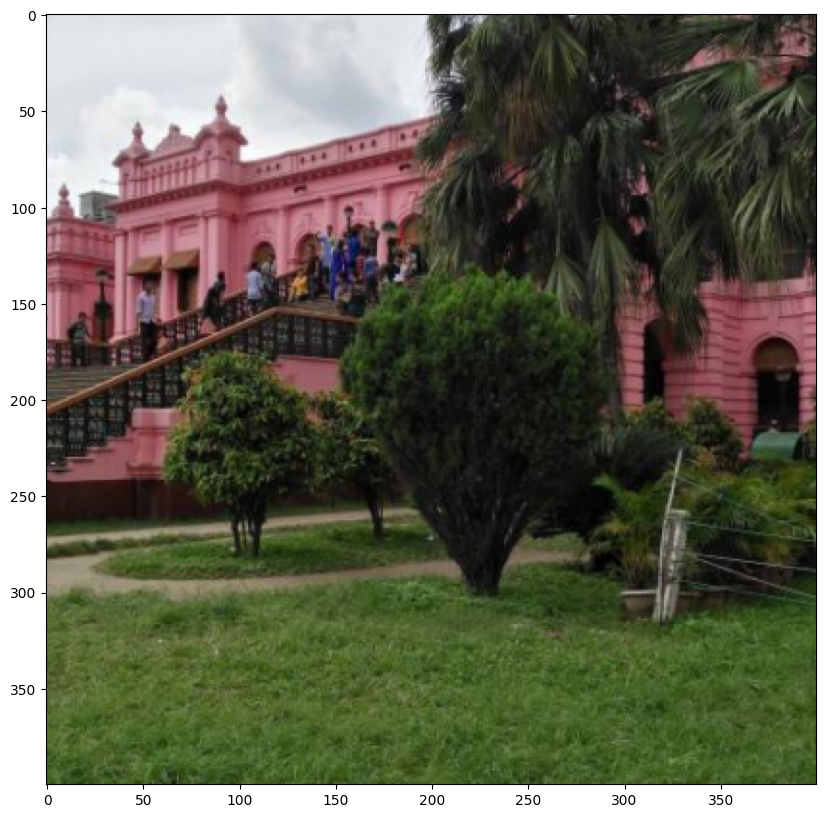

In [6]:
plot_img(train_dataset[10])

## Model & Arcface

In [7]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=10.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        return output

class GLRModel(tez.Model):
    def __init__(self, num_classes):
        super().__init__()
        self.convnet = torchvision.models.resnet34(pretrained=True)
        
        layer_index = 0
        for child in self.convnet.children():
            if layer_index <= 5:
                for param in child.parameters():
                    param.requires_grad = False
            layer_index += 1
        
        
    def forward(self, image):
        outputs = self.convnet(image)        
        return outputs

## Loss Function & Metric

In [8]:
def loss_function(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)
    
def count_correct(outputs, targets):
    outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    total_correct = np.sum(outputs == targets)
    
    return total_correct

## Training

In [9]:
NUM_CLASSES = df_train.label.nunique()
model = GLRModel(num_classes = NUM_CLASSES)
model.to(device)

metric_fc = ArcMarginProduct(1000, NUM_CLASSES, s=30, m=0.15, easy_margin=False)
metric_fc.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.005,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(train_data_loader) * EPOCHS)
optimizer = torch.optim.AdamW(optimizer_parameters, lr=LEARNING_RATE)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,
    num_training_steps=num_train_steps
)

best_loss = float('inf')
print(f'Model Training Started')

for epoch in range(EPOCHS):
        
    total_train_loss = 0.0
    total_train_correct = 0
    for batch_index, data in tqdm(enumerate(train_data_loader), total=len(train_data_loader)):        
        
        image = data['image']
        targets = data['targets']
        
        image = image.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        feature = model(image=image)        
        outputs = metric_fc(feature, targets)
        
        loss = loss_function(outputs, targets)
        
        with torch.no_grad():
            total_train_loss += loss.item()
            total_train_correct += count_correct(outputs, targets)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    total_valid_loss = 0.0
    total_valid_correct = 0
    with torch.no_grad():
        model.eval()
        metric_fc.eval()
        for batch_index, data in tqdm(enumerate(valid_data_loader), total=len(valid_data_loader)):
            image = data['image']
            targets = data['targets']
        
            image = image.to(device)
            targets = targets.to(device)
        
            feature = model(image=image)        
            outputs = metric_fc(feature, targets)
            
            validloss = loss_function(outputs, targets)
            total_valid_loss += validloss.item()            
            total_valid_correct += count_correct(outputs, targets)
            
        total_valid_loss = total_valid_loss / len(valid_data_loader)
        total_train_loss = total_train_loss / len(train_data_loader)
        print(f'Epoch: {epoch + 1} :: Training Loss: {total_train_loss:.4f}, Validation Loss: {total_valid_loss:.4f}')
        print(f'Training Accuracy: {total_train_correct / len(train_dataset) * 100:.2f}, Validation Accuracy: {total_valid_correct / len(valid_dataset) * 100:.2f}')
        
        if total_valid_loss < best_loss:
            torch.save(model.state_dict(), MODEL_PATH)
            best_loss = total_valid_loss

Model Training Started


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 1 :: Training Loss: 6.6645, Validation Loss: 4.3322
Training Accuracy: 17.03, Validation Accuracy: 35.56


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 2 :: Training Loss: 4.2797, Validation Loss: 3.4448
Training Accuracy: 37.26, Validation Accuracy: 46.41


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 3 :: Training Loss: 3.3599, Validation Loss: 2.9335
Training Accuracy: 48.75, Validation Accuracy: 54.41


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 4 :: Training Loss: 2.8529, Validation Loss: 2.5439
Training Accuracy: 55.86, Validation Accuracy: 60.11


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 5 :: Training Loss: 2.5131, Validation Loss: 2.3476
Training Accuracy: 60.83, Validation Accuracy: 62.41


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 6 :: Training Loss: 2.2657, Validation Loss: 2.1689
Training Accuracy: 64.42, Validation Accuracy: 65.51


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 7 :: Training Loss: 2.0634, Validation Loss: 2.0612
Training Accuracy: 67.46, Validation Accuracy: 67.57


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 8 :: Training Loss: 1.8932, Validation Loss: 1.8854
Training Accuracy: 70.09, Validation Accuracy: 70.43


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 9 :: Training Loss: 1.7524, Validation Loss: 1.8283
Training Accuracy: 72.32, Validation Accuracy: 71.04


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 10 :: Training Loss: 1.6546, Validation Loss: 1.7557
Training Accuracy: 73.76, Validation Accuracy: 72.34


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 11 :: Training Loss: 1.5596, Validation Loss: 1.6801
Training Accuracy: 75.35, Validation Accuracy: 73.19


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 12 :: Training Loss: 1.4834, Validation Loss: 1.6846
Training Accuracy: 76.48, Validation Accuracy: 73.42


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 13 :: Training Loss: 1.3980, Validation Loss: 1.5752
Training Accuracy: 77.74, Validation Accuracy: 76.25


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 14 :: Training Loss: 1.3245, Validation Loss: 1.5084
Training Accuracy: 78.97, Validation Accuracy: 76.71


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 15 :: Training Loss: 1.2606, Validation Loss: 1.4570
Training Accuracy: 79.88, Validation Accuracy: 77.65


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 16 :: Training Loss: 1.2115, Validation Loss: 1.4251
Training Accuracy: 80.78, Validation Accuracy: 77.50


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 17 :: Training Loss: 1.1582, Validation Loss: 1.3683
Training Accuracy: 81.65, Validation Accuracy: 78.58


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 18 :: Training Loss: 1.1088, Validation Loss: 1.3495
Training Accuracy: 82.29, Validation Accuracy: 79.62


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 19 :: Training Loss: 1.0866, Validation Loss: 1.2477
Training Accuracy: 82.86, Validation Accuracy: 80.58


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 20 :: Training Loss: 1.0365, Validation Loss: 1.2751
Training Accuracy: 83.54, Validation Accuracy: 79.99


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 21 :: Training Loss: 0.9875, Validation Loss: 1.2312
Training Accuracy: 84.23, Validation Accuracy: 81.23


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 22 :: Training Loss: 0.9603, Validation Loss: 1.2753
Training Accuracy: 84.79, Validation Accuracy: 80.10


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 23 :: Training Loss: 0.9277, Validation Loss: 1.1525
Training Accuracy: 85.23, Validation Accuracy: 82.30


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 24 :: Training Loss: 0.8891, Validation Loss: 1.2602
Training Accuracy: 85.84, Validation Accuracy: 80.48


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 25 :: Training Loss: 0.8602, Validation Loss: 1.2178
Training Accuracy: 86.34, Validation Accuracy: 81.38


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 26 :: Training Loss: 0.8422, Validation Loss: 1.1421
Training Accuracy: 86.63, Validation Accuracy: 82.14


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 27 :: Training Loss: 0.8244, Validation Loss: 1.1546
Training Accuracy: 87.03, Validation Accuracy: 82.10


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 28 :: Training Loss: 0.7922, Validation Loss: 1.1305
Training Accuracy: 87.55, Validation Accuracy: 82.71


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 29 :: Training Loss: 0.7634, Validation Loss: 1.0830
Training Accuracy: 87.97, Validation Accuracy: 83.70


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 30 :: Training Loss: 0.7503, Validation Loss: 1.0220
Training Accuracy: 88.22, Validation Accuracy: 84.11


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 31 :: Training Loss: 0.7261, Validation Loss: 1.0755
Training Accuracy: 88.62, Validation Accuracy: 83.65


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 32 :: Training Loss: 0.6999, Validation Loss: 1.0390
Training Accuracy: 88.95, Validation Accuracy: 84.07


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 33 :: Training Loss: 0.6871, Validation Loss: 1.0152
Training Accuracy: 89.22, Validation Accuracy: 84.72


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 34 :: Training Loss: 0.6605, Validation Loss: 1.0228
Training Accuracy: 89.62, Validation Accuracy: 84.39


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 35 :: Training Loss: 0.6420, Validation Loss: 0.9356
Training Accuracy: 90.01, Validation Accuracy: 85.61


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 36 :: Training Loss: 0.6351, Validation Loss: 0.9513
Training Accuracy: 90.15, Validation Accuracy: 85.68


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 37 :: Training Loss: 0.6149, Validation Loss: 0.9927
Training Accuracy: 90.36, Validation Accuracy: 85.23


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 38 :: Training Loss: 0.5953, Validation Loss: 0.9395
Training Accuracy: 90.69, Validation Accuracy: 86.04


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 39 :: Training Loss: 0.5821, Validation Loss: 0.9403
Training Accuracy: 90.89, Validation Accuracy: 85.72


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 40 :: Training Loss: 0.5555, Validation Loss: 0.9448
Training Accuracy: 91.38, Validation Accuracy: 85.90


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 41 :: Training Loss: 0.5454, Validation Loss: 0.9225
Training Accuracy: 91.53, Validation Accuracy: 86.11


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 42 :: Training Loss: 0.5337, Validation Loss: 0.9371
Training Accuracy: 91.68, Validation Accuracy: 86.04


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 43 :: Training Loss: 0.5290, Validation Loss: 0.8959
Training Accuracy: 91.85, Validation Accuracy: 86.63


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 44 :: Training Loss: 0.5116, Validation Loss: 0.8808
Training Accuracy: 92.11, Validation Accuracy: 86.57


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 45 :: Training Loss: 0.4913, Validation Loss: 0.8715
Training Accuracy: 92.41, Validation Accuracy: 86.88


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 46 :: Training Loss: 0.4846, Validation Loss: 0.8495
Training Accuracy: 92.53, Validation Accuracy: 87.15


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 47 :: Training Loss: 0.4692, Validation Loss: 0.8407
Training Accuracy: 92.84, Validation Accuracy: 87.28


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 48 :: Training Loss: 0.4677, Validation Loss: 0.8227
Training Accuracy: 92.83, Validation Accuracy: 87.53


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 49 :: Training Loss: 0.4480, Validation Loss: 0.8244
Training Accuracy: 93.12, Validation Accuracy: 87.50


  0%|          | 0/4246 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

Epoch: 50 :: Training Loss: 0.4487, Validation Loss: 0.8220
Training Accuracy: 93.19, Validation Accuracy: 87.53


In [10]:
NUM_CLASSES = df_train.label.nunique()
loaded_model = GLRModel(num_classes = NUM_CLASSES)
loaded_model.to(device)
loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()

total_test_correct = 0
index = 0
df_test['prediction'] = 'Missing Prediction'
with torch.no_grad():
        for batch_index, data in tqdm(enumerate(test_data_loader), total=len(test_data_loader)):
            image = data['image']
            targets = data['targets']
        
            image = image.to(device)
            targets = targets.to(device)
        
            feature = model(image=image)        
            outputs = metric_fc(feature, targets)
            total_test_correct += count_correct(outputs, targets)
            outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            for i in range(len(targets)):                            
                df_test['prediction'][index] = outputs[i]
                index += 1             

                
print(f'Test Accuracy: {total_test_correct / len(test_dataset) * 100:.2f}')       
df_test.to_csv(TEST_PREDICTION_FILE, sep=',')

  0%|          | 0/525 [00:00<?, ?it/s]

C:\Users\vibhatna\AppData\Local\Temp\ipykernel_19988\1833868793.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction'][index] = outputs[i]


Test Accuracy: 87.06


In [11]:
df_prediction = pd.read_csv(TEST_PREDICTION_FILE)
class_correct_count = {}
class_total_count = {}
index = 0
for label in df_prediction.label.values:
    if label not in class_total_count:
        class_total_count[label] = 0
        class_correct_count[label] = 0
        
    if label == df_prediction.prediction[index]:
        class_correct_count[label] += 1
    
    class_total_count[label] += 1
    index+=1


In [12]:
accuracy_sum = 0.0

with open(CLASS_ACCURACY_FILE, "w", newline='') as filec:
    writerc = csv.writer(filec, delimiter=',')
    writerc.writerow(('class_id','total_count', 'total_correct', 'accuracy'))
    
    for class_id, total_count in class_total_count.items():
        total_correct = class_correct_count[class_id]
        accuracy = total_correct / total_count * 100.0
        accuracy_sum += accuracy
        writerc.writerow((class_id, total_count, total_correct, round(accuracy, 2)))
        
        
print(f'Balanced Accuracy: {accuracy_sum / NUM_CLASSES :.2f}')

Balanced Accuracy: 86.39


Target: 29


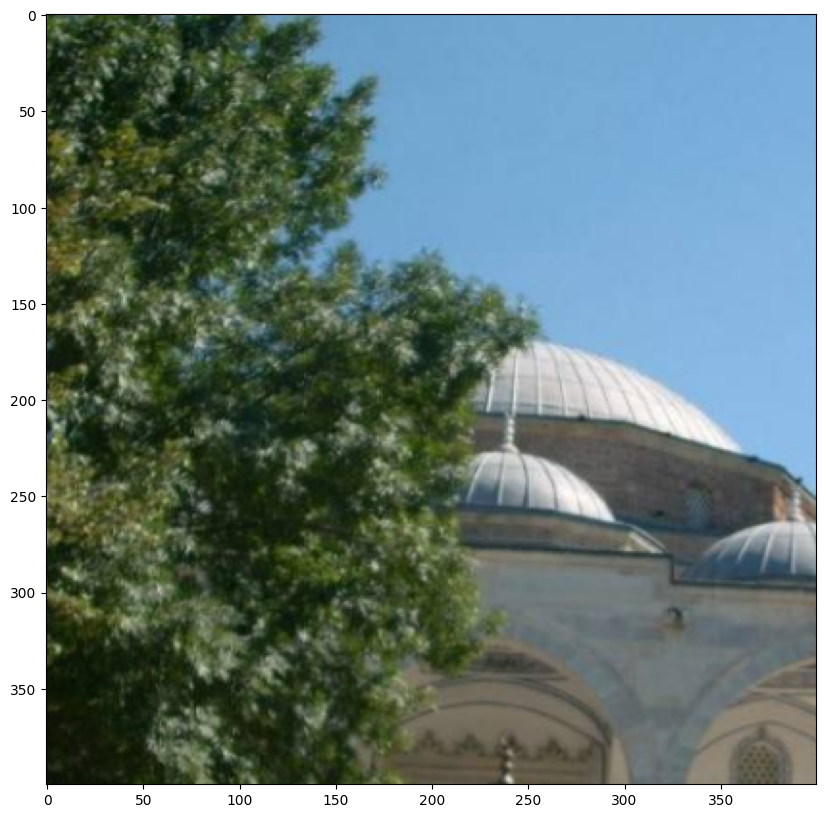

In [13]:
target_class = 29
target_class_index = 8
count = 0 
for index in range(len(train_dataset)):
    if train_dataset[index]['targets'] == target_class:
        count += 1        
        if count == target_class_index:        
            plot_img(train_dataset[index])
            break

In [14]:
torchvision.models.resnet34(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
torchvision.models.resnet34(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  